Name  - Satyapriya

Roll No - 22103057

Kaggle User Name - satyapriya100 

# Assignment 2
Crack Detection Image Classification
Given dataset consists of images obtained from concrete bridge decks, pavements, and walls, images can contain either cracks or no cracks. 

Challenge is to develop a binary image classification model to detect cracks in the concrete.

We will use a Transfer learing CNN model to make our predictions.

In [11]:
# This command is used to check the availability of GPU on the system
!nvidia-smi

Fri Apr 14 17:02:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Extracting dataset from Kaggle

In [2]:
#to install the Kaggle package
!pip install -q kaggle

In [3]:
#command is used to mount the Google Drive account for linking my google drive for kaggle.json file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# creating creates a new directory named .kaggle.
! mkdir ~/.kaggle

In [5]:
#copies the Kaggle API credentials from the Google Drive to the newly created .kaggle directory.
!cp /content/drive/MyDrive/Colab_Notebooks/Kaggle_Credential/kaggle.json ~/.kaggle/

In [6]:
#command changes the permission of the copied Kaggle API credential file read and write the file
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
#command to downloads the dataset of the competition "crack-detection-image-classification-2023" from Kaggle.
! kaggle competitions download -q -c crack-detection-image-classification-2023 

In [8]:
#command unzips the downloaded dataset.
! unzip -q crack-detection-image-classification-2023.zip 

# Importing all the Libraries

In [9]:
# import the libraries as shown below

import os
import cv2
from glob import glob
import tensorflow as tf   # import TensorFlow
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential, load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pathlib import Path

In [10]:
#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.12.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Creating DataFrames

In [12]:
TRAINING_EPOCHS = 20
BATCH_SIZE = 32

image_height = 256 
image_width = 256

In [13]:
from tensorflow.keras.utils import image_dataset_from_directory
base_dir = 'train/'

base_dataset = image_dataset_from_directory(base_dir,
                                            image_size = (image_height, image_width), 
                                            crop_to_aspect_ratio = True,
                                            shuffle = False,
                                            batch_size = 32)

Found 14968 files belonging to 2 classes.


In [14]:
base_df = pd.DataFrame(base_dataset.file_paths.copy())
base_df.columns = ['fullpaths']
base_df['labels'] = base_df.apply(lambda x: base_dataset.class_names[1] if (base_dataset.class_names[1] in x.fullpaths)  else base_dataset.class_names[0], axis=1)
base_df['filepaths'] = base_df.apply(lambda x: str(x.fullpaths).replace(base_dir, ''), axis=1)

In [15]:
base_df.head(-5)

,fullpaths,labels,filepaths
0,train/cracked/1000.jpg,cracked,cracked/1000.jpg
1,train/cracked/10000.jpg,cracked,cracked/10000.jpg
2,train/cracked/10003.jpg,cracked,cracked/10003.jpg
3,train/cracked/10004.jpg,cracked,cracked/10004.jpg
4,train/cracked/10005.jpg,cracked,cracked/10005.jpg
...,...,...,...
14958,train/uncracked/9985.jpg,uncracked,uncracked/9985.jpg
14959,train/uncracked/9986.jpg,uncracked,uncracked/9986.jpg
14960,train/uncracked/9988.jpg,uncracked,uncracked/9988.jpg
14961,train/uncracked/999.jpg,uncracked,uncracked/999.jpg


In [16]:
freq = base_df['labels'].value_counts()
print(freq)


cracked      7501
uncracked    7467
Name: labels, dtype: int64


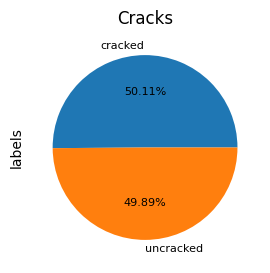

In [17]:
freq.plot(kind='pie', figsize=(3,3), title='Cracks', autopct='%1.2f%%',  shadow = False, fontsize=8);

# Loading Image Data

In [18]:
# 80% - train set,
# 10% - validation set,
# 10% - test set

from sklearn.model_selection import train_test_split

train_df, valid_df, test_df = np.split(base_df.sample(frac=1, random_state=42), [int(.8*len(base_df)), int(.9*len(base_df))])

train_df.head(-5)

,fullpaths,labels,filepaths
6560,train/cracked/8308.jpg,cracked,cracked/8308.jpg
1139,train/cracked/1199.jpg,cracked,cracked/1199.jpg
2478,train/cracked/14420.jpg,cracked,cracked/14420.jpg
5747,train/cracked/6782.jpg,cracked,cracked/6782.jpg
10491,train/uncracked/194.jpg,uncracked,uncracked/194.jpg
...,...,...,...
13774,train/uncracked/7868.jpg,uncracked,uncracked/7868.jpg
14941,train/uncracked/9958.jpg,uncracked,uncracked/9958.jpg
147,train/cracked/10266.jpg,cracked,cracked/10266.jpg
1668,train/cracked/12940.jpg,cracked,cracked/12940.jpg


In [19]:
# Use the Image Data Generator to import the images from the dataset
# Data agumentation and pre-processing using tensorflow
datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.05,
                                   horizontal_flip = True,
                                   vertical_flip   = True,
                                   rotation_range  = 25)

training_set = datagen.flow_from_dataframe(train_df, # dataframe 
                                          directory   = base_dir, # images data path / folder in which images are there
                                          x_col       = 'filepaths',
                                          y_col       = 'labels',
                                          color_mode  = "rgb",
                                          target_size = (image_height, image_width), # image height , image width
                                          class_mode  = "categorical",
                                          batch_size  = BATCH_SIZE,
                                          shuffle     = True,
                                          seed        = 42)

Found 11974 validated image filenames belonging to 2 classes.


In [20]:
test_datagen = ImageDataGenerator(rescale = 1./255)

val_set = test_datagen.flow_from_dataframe(valid_df, # dataframe 
                                      directory   =   base_dir, # images data path / folder in which images are there
                                      x_col       =   'filepaths',
                                      y_col       =   'labels',
                                      color_mode  =   "rgb",
                                      target_size =   (image_height, image_width), # image height , image width
                                      class_mode  =   "categorical",
                                      batch_size  =   BATCH_SIZE,
                                      shuffle     =   True,
                                      seed        =   42)

Found 1497 validated image filenames belonging to 2 classes.


In [21]:
test_set  =  test_datagen.flow_from_dataframe(test_df, # dataframe
                                              directory   = base_dir, # images data path / folder in which images are there
                                              x_col       = 'filepaths',
                                              y_col       = 'labels',
                                              color_mode  = "rgb",
                                              target_size = (image_height, image_width), # image height , image width
                                              class_mode  = "categorical",
                                              batch_size  = BATCH_SIZE,
                                              shuffle     = False)

Found 1497 validated image filenames belonging to 2 classes.


In [22]:
# Get labels in dataset
a = training_set.class_indices
class_names = list(a.keys())  # storing class names in a list
a

{'cracked': 0, 'uncracked': 1}

In [23]:
def plot_images(img, true_labels, predictions = None):
    plt.figure(figsize=[6, 8])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if (predictions is not None):
            plt.title("{}\n  {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
        else:
            plt.title(class_names[np.argmax(true_labels[i])])

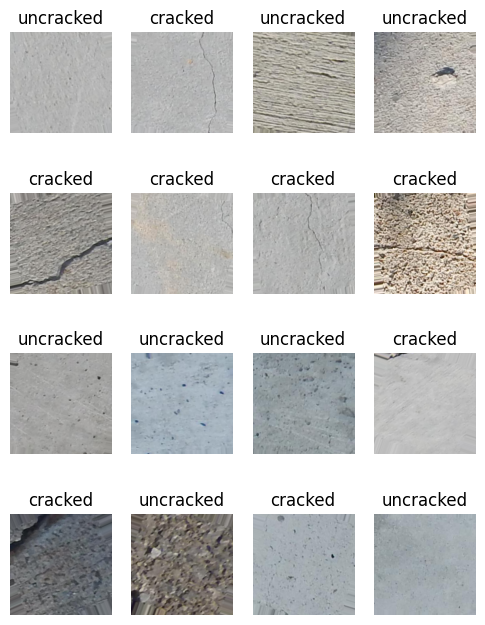

In [24]:
x, y = next(training_set)
plot_images(x, y)

# Loading Xception model

In [25]:
# Import the InceptionV3 library as shown below and add preprocessing layer to the front of InceptionV3
# Here we will be using imagenet weights
# command creates an InceptionV3 model with the specified input shape and pre-trained weights.
xception_base_model = tf.keras.applications.xception.Xception(include_top = False,
                                                              weights = 'imagenet',
                                                              input_shape = (image_height, image_width, 3))

83683744/83683744 [==============================] - 1s 0us/step


In [26]:
xception_base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [27]:
def create_model(base_model):
    
    x = base_model.output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(base_model.inputs, outputs)
    
    return model

In [28]:
xception_model = create_model(xception_base_model)

In [29]:
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

# Training Data

In [30]:
def fit_model(model, base_model, epochs, fine_tune = 0):
    # early stopping call back
    # monitors the validation loss during training and stops the training early
    es = tf.keras.callbacks.EarlyStopping(
                          monitor='val_loss',
                          min_delta = 0.02,
                          patience=6,
                          verbose=0,
                          mode='auto',
                          baseline=None,
                          start_from_epoch=10,
                          restore_best_weights=True)
    
    # saves the best model during training based on the validation loss
    model_cp = tf.keras.callbacks.ModelCheckpoint(filepath = 'best_model.h5', 
                                                  monitor='val_loss',
                                                  save_best_only = True,
                                                  verbose=1)

    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    
    print("Training number of layers in model = ", fine_tune)
    
    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:fine_tune]:
            layer.trainable = False       
        # small learning rate for fine tuning
        # tell the model what cost and optimization method to use
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        for layer in model.layers:
          print(layer.name,layer.trainable)
    else:
        base_model.trainable = False
        # tell the model what cost and optimization method to use
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        for layer in model.layers:
          print(layer.name,layer.trainable)       

    # fit the model
    # Run the cell. It will take some time to execute
    history = model.fit(training_set,
                        validation_data=val_set,
                        epochs= epochs,
                        steps_per_epoch=len(training_set),
                        validation_steps=len(val_set),
                        callbacks=[es,model_cp])
    
    return history

In [31]:
base_layers = len(xception_base_model.layers)
print("xception base layers = ", base_layers)    

xception base layers =  132


In [32]:
r = fit_model(xception_model, 
              xception_base_model, 
              epochs = TRAINING_EPOCHS, 
              fine_tune = int(base_layers/5))

Training last 26 number of layers in base model = 
Epoch 1/20
375/375 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.6592
Epoch 1: val_loss improved from inf to 0.48668, saving model to best_model.h5
375/375 [==============================] - 304s 705ms/step - loss: 0.6156 - accuracy: 0.6592 - val_loss: 0.4867 - val_accuracy: 0.7622
Epoch 2/20
375/375 [==============================] - ETA: 0s - loss: 0.4609 - accuracy: 0.7868
Epoch 2: val_loss improved from 0.48668 to 0.36699, saving model to best_model.h5
375/375 [==============================] - 244s 648ms/step - loss: 0.4609 - accuracy: 0.7868 - val_loss: 0.3670 - val_accuracy: 0.8504
Epoch 3/20
375/375 [==============================] - ETA: 0s - loss: 0.4028 - accuracy: 0.8204
Epoch 3: val_loss improved from 0.36699 to 0.33635, saving model to best_model.h5
375/375 [==============================] - 246s 656ms/step - loss: 0.4028 - accuracy: 0.8204 - val_loss: 0.3363 - val_accuracy: 0.8597
Epoch 4/20
375

In [34]:
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [33]:
# from tensorflow.keras.models import load_model

# # load best model
# model = load_model('best_model.h5')

# Plots

In [39]:
# creating a function for ploting the loss and Accuracy

def plot_model(r):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

    ax1.plot(r.history['loss'], label='train loss')
    ax1.plot(r.history['val_loss'], label='val loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title("Training and Validation Loss Over Time")


    ax2.plot(r.history['accuracy'], label='train acc')
    ax2.plot(r.history['val_accuracy'], label='val acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title("Training and Validation Accuracy Over Time")

    plt.show()
    plt.savefig('Plot')


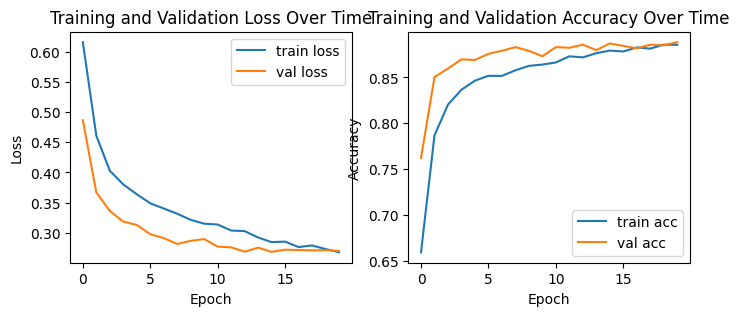

<Figure size 640x480 with 0 Axes>

In [40]:
plot_model(r)

# Results

In [44]:
# Results
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f} %".format(acc * 100))
    
    y_true = test_data.classes
    
    y_pred = np.argmax(model.predict(test_data), axis=1)
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    clr = classification_report(test_data.labels, y_pred, target_names=class_names) #["POSITIVE", "NEGATIVE"])
    
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, square=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=class_names)
    plt.yticks(ticks=np.arange(2) + 0.5, labels=class_names)
    plt.xlabel("Predicted Label", fontsize= 10)
    plt.ylabel("True Label", fontsize= 10)
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

    f1 = f1_score(test_data.labels, y_pred)
    print(f1)


    Test Loss: 0.28024
Test Accuracy: 88.11 %
47/47 [==============================] - 9s 175ms/step
[[668  97]
 [ 81 651]]


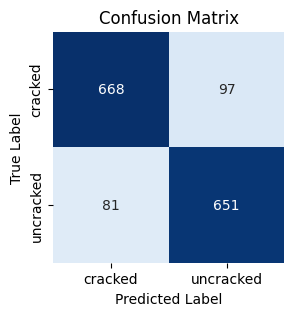

Classification Report:
----------------------
               precision    recall  f1-score   support

     cracked       0.89      0.87      0.88       765
   uncracked       0.87      0.89      0.88       732

    accuracy                           0.88      1497
   macro avg       0.88      0.88      0.88      1497
weighted avg       0.88      0.88      0.88      1497

0.8797297297297298


In [45]:
evaluate_model(xception_model, test_set)

# Predictions

In [46]:
test_path = 'test'
test_filenames = os.listdir(test_path)

In [47]:
test_predictions = np.array([])

for img in os.listdir(test_path):
    image_path = os.path.join(test_path,img)
    image_path
    image = tf.keras.utils.load_img(image_path, target_size = (256,256))
    image = tf.keras.utils.img_to_array(image)
    image = np.array([image])
    image = image/255
    y_pred = xception_model.predict(image)
    y_pred_classes = np.argmax(y_pred)
    test_predictions = np.append(test_predictions, class_names[y_pred_classes])
    #break
#print(test_predictions[0])
#print(test_labels[0])

1/1 [==============================] - 0s 22ms/step


# Output file

In [48]:
# Create a DataFrame with the filename and predicted values
results_df = pd.DataFrame({
    "filename": test_filenames,
    "class": test_predictions
})

# Save the DataFrame to a CSV file
results_df.to_csv("A2_22103057_Satyapriya.csv", index=False)

# Uploading to Kaggle

In [49]:
! kaggle competitions submit -c crack-detection-image-classification-2023 -f /content/A2_22103057_Satyapriya.csv -m test_submission_1

100% 34.2k/34.2k [00:01<00:00, 22.3kB/s]
Successfully submitted to Crack Detection: Image Classification 2023

In [50]:
! kaggle competitions submissions -c crack-detection-image-classification-2023

fileName                        date                 description                   status    publicScore  privateScore  
------------------------------  -------------------  ----------------------------  --------  -----------  ------------  
A2_22103057_Satyapriya.csv      2023-04-14 18:38:52  test_submission_1             complete  0.89000                    
newfile                         2023-04-14 17:03:52  Notebook newfile | Version 2  complete  0.80200                    
submission.csv                  2023-04-14 16:50:00  new file                      complete  0.80100                    
A2_22103057_Satyapriya.csv      2023-04-13 14:53:16  test_submission_1             complete  0.78300                    
A2_22103057_Satyapriya.csv      2023-04-12 16:05:45  test_submission_1             complete  0.81400                    
A2_22103057_Satyapriya (1).csv  2023-04-12 16:00:49  new file                      complete  0.75600                    
A2_22103057_Satyapriya.csv      

In [51]:
! kaggle competitions leaderboard -s -c crack-detection-image-classification-2023

  teamId  teamName               submissionDate       score    
--------  ---------------------  -------------------  -------  
10200611  Satyapriya             2023-04-14 18:38:52  0.89000  
10193103  Akshit Singh Chauhan   2023-04-09 11:30:29  0.88400  
10188189  Shubhi Kant            2023-04-12 17:33:42  0.88000  
10181370  Padam Sharma           2023-04-06 17:34:30  0.87000  
10188870  Ayush Gupta            2023-04-10 11:15:23  0.84800  
10191342  Huzaifa0498            2023-04-12 20:26:15  0.81000  
10182251  apsingh007             2023-04-10 20:12:42  0.80900  
10181135  LALIT CHOUDHARY        2023-04-13 06:51:31  0.79400  
10211836  ABHISHEK_MOURYA_04     2023-04-14 17:31:25  0.79400  
10185034  Gowri Naidu            2023-04-11 17:30:37  0.76800  
10194748  Ranjan9779             2023-04-13 20:21:06  0.73100  
10182822  priyanshu maddheshiya  2023-04-13 16:02:26  0.71400  
10219377  Analyst573             2023-04-14 12:53:59  0.71400  
10215427  SATISH KUMAR           2023-04